In [1]:
import os
import ast
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm

from IPython.display import display
from PIL import Image
from pathlib import Path
from os import PathLike
from typing import Dict, Any

from ba_dev.utils import plot_image_with_bbox


In [2]:
plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

In [3]:
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_model_metrics(
        metrics: PathLike | pd.DataFrame,
        title: str | None=None,
        type: str='valid', 
        step: bool=False, 
        image_size_cm: list[int]=[14,7], 
        window_size: int=5
        ):

    """
    Plot the training and validation metrics of a run.

    Parameters:

        run (str): Run name.
        type (str): Type of metrics ('train', 'valid'). Default is 'valid'.
        step (bool): for type 'train', plot step instead of epoch. Default is False.
        image_size_cm (list): Size of the output image in cm.
        window_size (int): Size of the smoothing window. Default is 5.

    """
    if isinstance(metrics, PathLike):
        metrics = pd.read_csv(metrics)

    if type == 'valid':
        loss = 'val_loss'
        acc = 'val_acc'
        label = ['Validation Loss', 'Validation Accuracy']
    elif type == 'train':
        label = ['Training Loss', 'Training Accuracy']
        if step:
            loss = 'train_loss_step'
            acc = 'train_acc_step'
        else:
            loss = 'train_loss_epoch'
            acc = 'train_acc_epoch'

    validation_data = metrics[~metrics[loss].isnull()]

    # Smooth the data
    smoothed_val_loss = smooth_data(validation_data[loss], window_size=window_size)
    smoothed_val_acc = smooth_data(validation_data[acc], window_size=window_size)

    # Adjust the epoch range to match the length of the smoothed data
    epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

    fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

    if title:
        plt.title(title)

    # Plot unsmoothed valid_loss on the primary y-axis
    ax1.plot(validation_data['epoch'], validation_data[loss], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_loss on the primary y-axis
    ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label=label[0], linewidth=0.5)


    # Adjust y-axis limits for loss
    loss_min = float(validation_data[loss].min())
    loss_max = float(validation_data[loss].max())
    ax1.set_ylim(loss_min * 0.87, loss_max * 1)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(label[0])
    ax1.tick_params(axis='y')

    # Create a secondary y-axis to plot valid_acc
    ax2 = ax1.twinx()
    # Plot unsmoothed valid_acc on the secondary y-axis
    ax2.plot(validation_data['epoch'], validation_data[acc], color='#FB9A99', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_acc on the secondary y-axis
    ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label=label[0], linewidth=0.5)
    ax2.set_ylabel(label[1])
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2)

    fig.tight_layout()
    
    return fig

In [38]:
class LoadRun:
    def __init__(
        self,
        log_path: str | PathLike
    ):
        self.log_path = Path(log_path)
        self.info = self.get_experiment_info()
        self.cross_val = self.info['cross_val']['apply']
        if self.cross_val:
            self.folds = range(2 if self.info.get('dev_run', False) else self.info['cross_val']['n_splits'])
        else:
            self.folds = [None]

        self.ds_path = Path(self.info['paths']['dataset'])
        self.dataset = self.get_dataset()

    def calculate_metrics(
            self,
            metric: str,
            **kwargs
            ):
        
        func = getattr(skm, metric, None)
        if func is None:
            raise ValueError(f"Metric '{metric}' not found in sklearn.metrics")

        def compute(df_pred: pd.DataFrame):
            y_true = df_pred['class_id']
            y_pred = df_pred['pred_id']
            return func(y_true, y_pred, **kwargs)
        
        if self.cross_val:
            results = []
            for fold in self.folds:
                df_pred = self.get_predictions(fold=fold)
                results.append(compute(df_pred))
            return results
        else:
            df_pred = self.get_predictions()
            return compute(df_pred)

    def get_sample(
            self,
            idx: int
            ) -> Dict[str, Any]:
        
        return {
            'idx': idx,
            'class_label': self.dataset.iloc[idx]['class_label'],
            'class_id': self.dataset.iloc[idx]['class_id'],
            'seq_id': self.dataset.iloc[idx]['seq_id'],
            'path': self.ds_path / self.dataset.iloc[idx]['file_path'],
            'bbox': self.dataset.iloc[idx]['bbox'],
            'conf': self.dataset.iloc[idx]['conf']
            }

    def get_experiment_info(self) -> Dict:
        yaml_path = self.log_path / 'experiment_info.yaml'
        if not yaml_path.exists():
            raise FileNotFoundError(f"Experiment info file not found at {yaml_path}")
        with open(yaml_path, 'r') as f:
            return yaml.safe_load(f)

    def get_dataset(self) -> pd.DataFrame:
        csv_path = self.log_path / 'dataset.csv'
        if not csv_path.exists():
            raise FileNotFoundError(f"Dataset file not found at {csv_path}")
        df = pd.read_csv(csv_path)
        return self._enforce_dtypes_and_idx(df)

    def get_predictions(
            self,
            fold: int | None = None,
            ) -> pd.DataFrame:
        
        prediction_path = self._handle_crossval_or_not('predictions', fold)

        df = pd.read_csv(prediction_path)

        df['correct'] = df['class_id'] == df['pred_id']

        df = self._enforce_dtypes_and_idx(df)

        if 'probs' in df.columns:
            df['probs_max'] = [
                prob_list[pred]
                for prob_list, pred in zip(df['probs'], df['pred_id'])
            ]

        return df
    
    def get_metrics(
            self,
            fold: int | None = None,
            ) -> pd.DataFrame:
        
        metrics_path = self._handle_crossval_or_not('metrics', fold)

        df = pd.read_csv(metrics_path)
        df = self._enforce_dtypes_and_idx(df)

        return df
    
    def _handle_crossval_or_not(
            self,
            type: None | str = None,
            fold: None | int = None,
            ) -> Path:
        
        options = {'metrics': 'metrics.csv', 'predictions': 'predictions.csv'}
        if type not in options:
            raise ValueError(f"Type must be one of {options.keys()}")
        
        if self.cross_val:
            if fold is None:
                raise ValueError("Fold number must be provided for cross-validation runs.")
            predictions_path = self.log_path / f'fold_{fold}' / options[type]
        else:
            predictions_path = self.log_path / options[type]

        if not predictions_path.exists():
            raise FileNotFoundError(f"{type} file not found at {predictions_path}")
        
        return predictions_path

    def _enforce_dtypes_and_idx(
            self,
            df: pd.DataFrame
            ) -> pd.DataFrame:
        df.insert(0, 'idx', df.index)
        cast_map = {
            'seq_id': 'int64',
            'class_id': 'int8',
            'fold': 'int8',
        }
        existing_casts = {k: v for k, v in cast_map.items() if k in df.columns}
        df = df.astype(existing_casts)

        def to_float_list(x):
            if isinstance(x, str):
                x = ast.literal_eval(x)
            return [float(i) for i in x]
        
        for col in ['bbox', 'probs']:
            if col in df.columns:
                df[col] = df[col].apply(to_float_list)

        return df

In [39]:
run = LoadRun(
        log_path='/cfs/earth/scratch/kraftjul/BA/output/runs/efficientnet_b0_v3_from_scratch'
        # log_path='/cfs/earth/scratch/kraftjul/BA/output/runs/efficientnet_b0_cross_val_dev'
        )

In [ ]:
labels = list(run.info['output']['label_decoder'].values())

['apodemus_sp', 'mustela_erminea', 'cricetidae', 'soricidae']

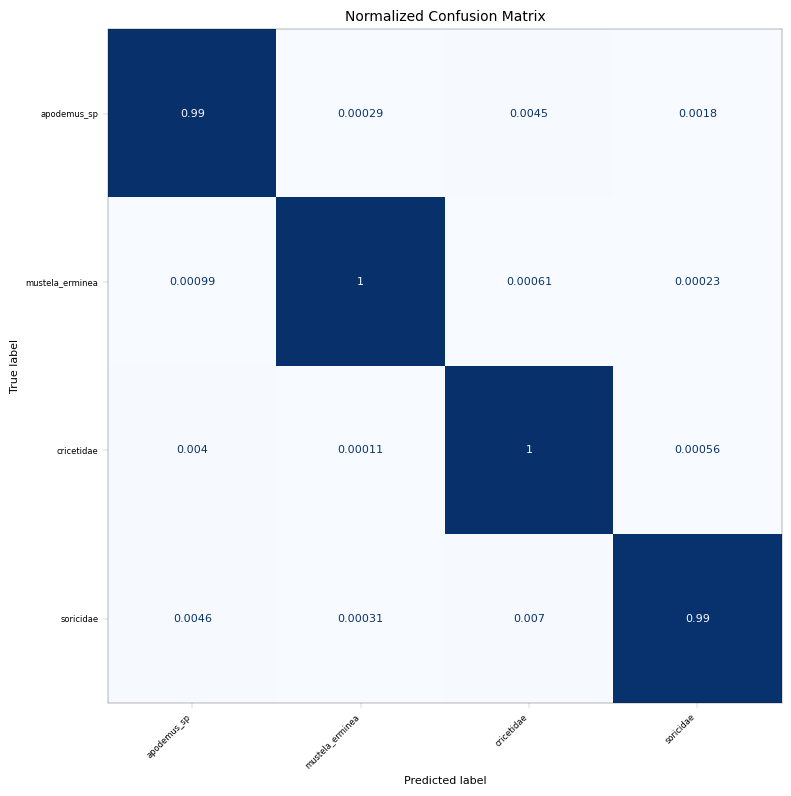

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Get human-readable labels from your decoder
labels = list(run.info['output']['label_decoder'].values())

# 2) Compute the normalized confusion matrix
cm = run.calculate_metrics(
    'confusion_matrix',
    labels=[0, 1, 2, 3],       # integer class IDs
    normalize='true'           # row-wise normalization
)

# 3) Create and plot the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)  # you can enable the colorbar if you like
ax.set_title("Normalized Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
f1

array([[9.93421129e-01, 2.92223397e-04, 4.51792752e-03, 1.76872056e-03],
       [9.86717268e-04, 9.98178368e-01, 6.07210626e-04, 2.27703985e-04],
       [4.01656487e-03, 1.10801789e-04, 9.95311699e-01, 5.60934059e-04],
       [4.61658842e-03, 3.12989045e-04, 7.04225352e-03, 9.88028169e-01]])

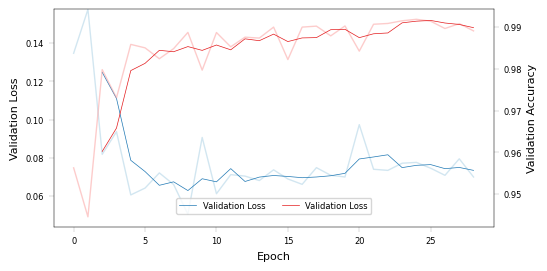

In [9]:
# Plotting validation metrics of efficientnet_b0_v3_from_scratch

metrics = run.get_metrics()
best_model_loss = plot_model_metrics(
                        metrics=metrics,
                        title=None,
                        type='valid', 
                        step=False, 
                        image_size_cm=[14,7], 
                        window_size=3
                        )

class_id: 0


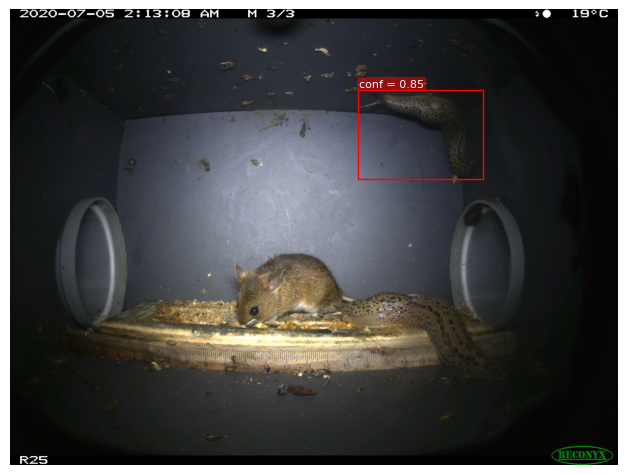

class_id: 0


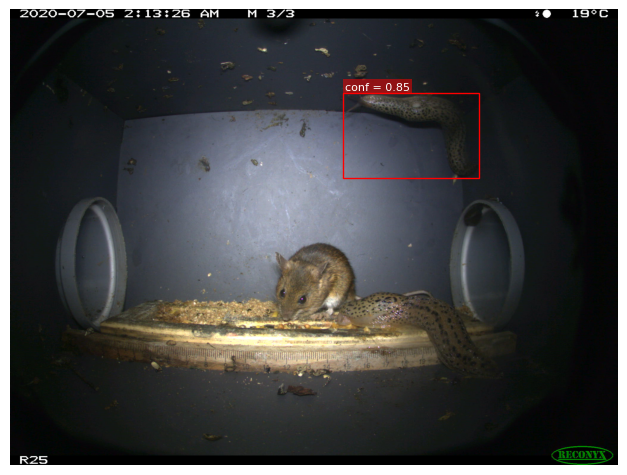

In [7]:
df = run.get_prediction()
idx_to_check = df[df['correct'] == False].sort_values(by='probs_max', ascending=False).iloc[0:2]['idx'].tolist()

for idx in idx_to_check:

        sample = run.get_sample(idx)

        print(f'class_id: {sample["class_id"]}')

        plot = plot_image_with_bbox(
                image=Image.open(sample['path']),
                bbox=sample['bbox'],
                conf=sample['conf']
                )

        display(plot)